In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data2_textonly.csv')

THEME = "CHALLENGING"

filter_topics_includes = ["Challenging traditional ways"]

print(len(df))
len(df.dropna(subset=['topics']))
df = df.dropna(subset=['topics'])
df = df[sum([df['topics'].str.contains(topic) for topic in filter_topics_includes])>=1]
vb = df['text']
vb = vb.dropna().reset_index()
print(len(df))
# vb = vb.iloc[0:500] # for faster performance, limit data in

55072
3198


In [2]:
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
import pyLDAvis.gensim_models

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain

c:\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Python310\lib\site-packages\joblib\backports.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [3]:
vb = vb.rename(columns={'Q46_Strengthen_EN':'text'}).drop(columns=['index'])
vb

text
0     With the increased attrition, we need to stren...
1     Continue to knock down silos to improve collab...
2                                 Courage of Conviction
3                     Promoting a spirit of innovation.
4     Challenging the norm and doing things just bec...
...                                                 ...
3193  I genuinely believe the culture of forced, com...
3194  Status quo. It feels like we have only tried t...
3195  Working to make teams and people feel trusted,...
3196  I am interested in innovation, entrepreneurshi...
3197  Improving psychological safety where people ca...

[3198 rows x 1 columns]

In [4]:
# clean
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

vb['clean'] = vb.text.apply(lambda x: clean(x))
vb

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SB579KE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SB579KE\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


text  \
0     With the increased attrition, we need to stren...   
1     Continue to knock down silos to improve collab...   
2                                 Courage of Conviction   
3                     Promoting a spirit of innovation.   
4     Challenging the norm and doing things just bec...   
...                                                 ...   
3193  I genuinely believe the culture of forced, com...   
3194  Status quo. It feels like we have only tried t...   
3195  Working to make teams and people feel trusted,...   
3196  I am interested in innovation, entrepreneurshi...   
3197  Improving psychological safety where people ca...   

                                                  clean  
0     [increased, attrition, need, strengthen, hando...  
1     [continue, knock, silo, improve, collaboration...  
2                                 [courage, conviction]  
3                       [promoting, spirit, innovation]  
4     [challenging, norm, thing, done, past, andor, ...  
...                                                 ...  
3193  [genuinely, believe, culture, forced, competit...  
3194  [status, quo, feel, like, tried, maintain, sta...  
3195  [working, make, team, people, feel, trusted, e...  
3196  [interested, innovation, entrepreneurship, ele...  
3197  [improving, psychological, safety, people, wit...  

[3198 rows x 2 columns]

In [5]:
dictionary = corpora.Dictionary(vb.clean)
print('Unique Words:', dictionary.num_nnz)

Unique Words: 54209


In [6]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in vb.clean]
print(len(doc_term_matrix))

3198


In [7]:
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)

In [8]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [9]:
lda_corpus = ldamodel[doc_term_matrix]

In [10]:
x = [doc for doc in lda_corpus]
x[3]

[(0, 0.062633246), (1, 0.06250601), (2, 0.8122279), (3, 0.06263285)]

In [11]:
scores = list(chain(*[[score for topic_id, score in topic] for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores) / len(scores)
print(threshold)

0.2500000001088254


In [12]:
cluster1 = [j for i,j in zip(lda_corpus,vb.index) if i[0][1] > threshold]
x = [doc for doc in lda_corpus]
prefix = 'cluster_fit_'
c_scores = [doc for doc in lda_corpus]

cluster_fit_cols = []

for i in range(len(lda_corpus[0])):
    cluster_id = i + 1
    new_cluster_fit_col = f"{prefix}{str(cluster_id)}"
    cluster_fit_cols.append(new_cluster_fit_col)
    vb[new_cluster_fit_col] = [c_scores[j][i][1] for j in range(len(lda_corpus))]


vb.to_csv('lda_cluster_results.csv')

In [13]:
number_top_comments_per_cluster = 20
max_comments = {}

for cluster_fit_col in cluster_fit_cols:
    max_fit_vb = vb.sort_values(cluster_fit_col,ascending=False).iloc[0:5]
    max_comments[cluster_fit_col] = max_fit_vb.text.tolist()

In [14]:
import json
filename = "lda_cluster_results_with_top"
json_path = f"{filename}.json"
csv_path = f"{filename}.csv"
with open(json_path,'w') as file:
    json.dump(max_comments, file)
pd.read_json(json_path).to_csv(csv_path)

In [15]:
# from wordcloud import WordCloud

# word_cloud = WordCloud(collocations=False, background_color='white').generate(" ".join(vb.text.tolist()))
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

result_best_fit_clusters = []

for index, row in vb.iterrows():
    best_fit_cluster = [cluster_col_name for cluster_col_name in cluster_fit_cols if row[cluster_col_name]>threshold][0]
    result_best_fit_clusters.append(best_fit_cluster)

best_fit_cluster_name = f'{THEME}_best_fit_cluster'

vb[best_fit_cluster_name] = result_best_fit_clusters

cluster_fit_1


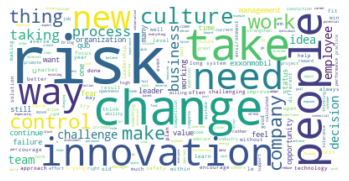

cluster_fit_2


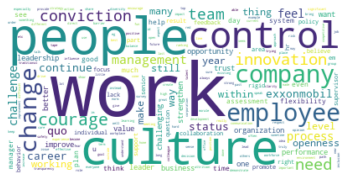

cluster_fit_3


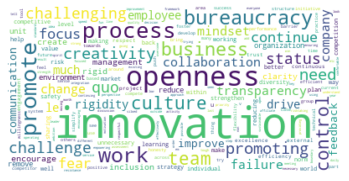

cluster_fit_4


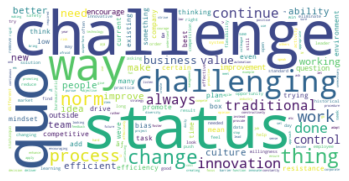

In [16]:
from wordcloud import WordCloud

cluster_fit_names = vb[f'{THEME}_best_fit_cluster'].unique().tolist()

excel_output_name = f"{THEME}_by_subtopic.xlsx"

with pd.ExcelWriter(excel_output_name) as xlsx_writer:
    for cluster_fit_name in sorted(cluster_fit_names):
        print(cluster_fit_name)
        # clean up the clean text for word cloud
        vb_current_cluster = vb[vb[best_fit_cluster_name]==cluster_fit_name]
        vb_current_cluster['clean_joined_text'] = [' '.join(clean_text_list) for clean_text_list in vb_current_cluster.clean.tolist()]

        # write to excel sheet
        sheet_name = f"{cluster_fit_name}"
        vb_current_cluster.to_excel(xlsx_writer, sheet_name=sheet_name, index=False)

        # generate word cloud
        word_cloud = WordCloud(collocations=False, background_color='white').generate(' '.join(vb_current_cluster.clean_joined_text.tolist()))
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis('off')
        plt.savefig(f"wordcloud_{THEME}_{cluster_fit_name}.png")
        plt.show()

# Subtopic Analysis

## Cluster 1: Taking Risks
### Word Cloud
![](wordcloud_CHALLENGING_cluster_fit_1.png)
### Key Verbatims

* ExxonMobil tends to look at opportunities in isolation.  To improve the business during the energy transition, we need to think about the synergies which may present across different opportunities, especially when an activity which is a facilitating activity is not overly profitable in itself, but is required to facilitate other opportunities. ExxonMobil culture is quite conservative including Senior Management) often taking the "safe" option, instead of the one which may expose them to personal risk, but which may be the right or better solution.  We need to change the culture to support prudent risk taking, understanding that at times we will not succeed. We need to fully utilise the experience of our people and reward loyalty.
* We need to become more nimble. Experiment more for lower risk low cost decisions. Remove fears of admitting to being wrong or needs to pivot. One example is our reluctance to experiment in the renewable space. Just because we have always labelled it as low return/not fit for our expertise/wont have a significant future/not reliable in the past doesn't mean we should not experiment in this space. We are afraid of contradicting what we have said in the past.
* Be more tolerant of new ideas & open to taking risk.  Our risk aversion runs deep, to the point where we mostly play not to lose.  We could create more value w/ fewer person-hours if we were less concerned about making a good impression w/ management & more focused on quality dialogue w/ a tolerance & EXPECTATION of making mistakes.

## Cluster 2: Courage of Conviction
### Word Cloud
![](wordcloud_CHALLENGING_cluster_fit_2.png)
### Key Verbatims

* Help senior managers to listen and learn from their subordinates.  We've gotten too many in place that want to exclusively be "teachers" and don't demonstrate the learning behavior.  Current trendy business buzzwords like "Lean In" are being mis-used by our leaders as weapons to force alignment of singular thought and discourage healthy debate and support of differing opinions.  Despite intentional cultural change initiatives over the last 5-years, our division has become more "Command and Control" than ever before. Additional to that, I would like to see our company change its geographical policy on employee work locations to include more flexibility so we can truly attract and retain the best workforce, not just the ones local to HOU
* Two key aspects of good leadership - namely "Adaptability" and "Courage of Conviction" more often than not requires employees to walk a fine line striking a good balance between the two. It will be great if there is an improvement in working culture among teams where employees are given more flexibility to demonstrate both behavioral skills but not treated good/bad for leaning towards one side more than the other. End of the day, if it helps to benefit the organization both from a reputation and profitability stand-point, it should be encouraged.
* Courage of Conviction: Bringing my whole self to work. Voicing my opinions, even if they are unpopular, even though I have faced rebuke during PDS for the same. Supporting others when they make unpopular opinions.
* I will continue to use courage of conviction to be a voice for younger team members, many of whom have been disenchanted.  Canned responses by management to difficult questions are not effective.

## Cluster 3: Innovation and Openness
### Word Cloud
![](wordcloud_CHALLENGING_cluster_fit_3.png)
### Key Verbatims

* Discard all notion of "competition" among colleagues in everyday behavior.  These are teammates and, in many cases, genuine friends.  The competition is outside the fence line. Decades of focus on peer ranking has eroded EM's ability to collaborate and has traded a collective, competitive business spirit for a performance-driven mercenary culture.  Innovation becomes tougher than it needs to be when we mistake teammates for competitors.
* I would like to see more openness to external engagements / communications, and a better process and resourcing to enable the responsiveness to our participation in external forums/dialogues around the world, including the equipping/training of key leaders/managers with the material that they need to do so effectively.
* Overcome the fear of failure that many employees experience by humbly seeking feedback and improving. I will in turn foster an environment where others feel comfortable receiving correction and instruction by listening and learning from them.
* Strategically setting the boundaries and empowering teams to work / handle issues as opposed to doing the same as we did it before. Spark creativity and innovation to drive competitiveness.

## Cluster 4: Challenging Norms
### Word Cloud
![](wordcloud_CHALLENGING_cluster_fit_4.png)
### Key Verbatims

* Just because the task had been done in a way for a long time, think outside the box, is the existing process the best way? You can think how to enhance a process keeping control requirements and safety in mind. We need to everything as per procedures, we complete LPOs that we do as per procedure, but that doesn't mean we can't enhance the existing procedure. We forget that, or just not motivated to change existing procedures. We need to change this mindset. On the other hand don't change those processes what is working well, just to show change happened, but 0 benefit at the end, put your energy there, where you see rewards at the end.
* Challenging the norms and why things get done. Every time I get a new role, I find a few low value items that I simply don't do. I've only ever had one item from one job where someone even noticed that the item was no longer getting done, which clearly shows that all the other activities had no value. I won't do stuff simply because I'm told to, I'll do work that adds value.
* Challenging the status-quo; this company has too many yes-men that refuse to push-back against management and business customers.  I actively fight this complacency on a daily basis, because by complying and doing what I am told, I would be absolutely miserable.
* Actively promoting and challenging the mindset of doing things a certain way simply because its the way we've always done them, fostering innovation in our processes to improve efficiency. Challenging our mindset around staffing by trying to shift focus away from plan-on-plan and year-on-year changes, and instead focusing on differences between industry peers and how changes will make us more competitive.